 # Introduction to Quantum Computation
 
 
 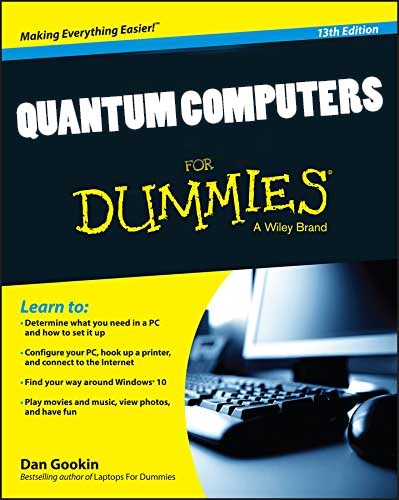

The aim of this tutorial is to show all of you how simple and straightforward it is to use an actual quantum computer. Maybe somebody will get inspired!

First, let us import some python packages and define useful functions. We will be using an [IBM quantum computer](https://www.ibm.com/quantum-computing/) and communicate with it using both the [IBM qiskit](https://qiskit.org/documentation/install.html) package and the [pennylane](https://pennylane.ai/install.html) package (with [qiskit plugin](https://pennylane-qiskit.readthedocs.io/en/latest/installation.html)) developed by [Xanadu](https://www.xanadu.ai/) in Toronto.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

def plot_rho(rho):
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.real(rho), clim=(0,0.5))
    plt.colorbar()
    plt.title(r"Re[$\rho_{exp}$]");
    plt.subplot(122)
    plt.imshow(np.imag(rho), clim=(0,0.5))
    plt.colorbar()
    plt.title(r"Im[$\rho_{exp}$]");


# Quantum circuits

Quantum circuit start with a bunch of qubits all in the state $\ket{0}$ and then apply a bunch of unitary gates. Finally, a measurement in the computational basis (z-basis) is performed.

Here is a list of the most important gates and their implementation in qiskit.

### Pauli-gates

In [162]:
# Create a Quantum Circuit acting on a quantum register of one qubit
qc = QuantumCircuit(1)
# Apply gates
qc.x(0)
qc.y(0)
qc.z(0)
print(qc)

        ┌───┐┌───┐┌───┐
q_0: |0>┤ X ├┤ Y ├┤ Z ├
        └───┘└───┘└───┘


### Hadamard gate

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
,
\quad
H \ket{0} = \ket{+}
,
\quad
H \ket{1} = \ket{-}
,
\quad
H \ket{+} = \ket{0}
,
\quad
H \ket{-} = \ket{1}
$$

In [163]:
qc = QuantumCircuit(1)
qc.h(0)
print(qc)

        ┌───┐
q_0: |0>┤ H ├
        └───┘


### S gate (phase gate)

$$
S = \begin{pmatrix}
1 & 0\\
0 & i
\end{pmatrix}
,
\quad
S \ket{+} = \frac{1}{\sqrt{2}}\left(\ket{0} + i \ket{1}\right) = \ket{\circlearrowright}
,
\quad
S \ket{-} = \frac{1}{\sqrt{2}}\left(\ket{0} - i \ket{1}\right) = \ket{\circlearrowleft}
$$

In [164]:
qc = QuantumCircuit(1)
qc.s(0)
print(qc)

        ┌───┐
q_0: |0>┤ S ├
        └───┘


### Controlled Not (CX, CNOT)

$$
CX\ket{00} = \ket{00}, \quad
CX\ket{01} = \ket{01}, \quad
CX\ket{10} = \ket{11}, \quad
CX\ket{11} = \ket{10}
$$

In [165]:
qc = QuantumCircuit(2)
qc.cx(0,1)
print(qc)

             
q_0: |0>──■──
        ┌─┴─┐
q_1: |0>┤ X ├
        └───┘


### Controlled Z (CZ)

$$
CZ\ket{00} = \ket{00}, \quad
CZ\ket{01} = \ket{01}, \quad
CZ\ket{10} = \ket{10}, \quad
CZ\ket{11} = -\ket{11}
$$

In [166]:
qc = QuantumCircuit(2)
qc.cz(0,1)
print(qc)

           
q_0: |0>─■─
         │ 
q_1: |0>─■─
           


# Bell singlet

One of the simplest nontrivial quantum states is the Bell singlet state
$$|\Psi\rangle = \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle),$$. We implement it with the quantum circuit below.

In [167]:
# Create a Quantum Circuit acting on a quantum register of two qubits
qc = QuantumCircuit(2)
# Apply a bunch of unitary gates
qc.x([0,1])
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print(qc)

             ┌───┐┌───┐      ░ ┌─┐   
     q_0: |0>┤ X ├┤ H ├──■───░─┤M├───
             ├───┤└───┘┌─┴─┐ ░ └╥┘┌─┐
     q_1: |0>┤ X ├─────┤ X ├─░──╫─┤M├
             └───┘     └───┘ ░  ║ └╥┘
measure_0: 0 ═══════════════════╩══╬═
                                   ║ 
measure_1: 0 ══════════════════════╩═
                                     


Does this circuit really do what we want? Let's check, step by step:
$$
\ket{00}\rightarrow \ket{11} \rightarrow \frac{1}{2}\left(\ket{01} - \ket{11} \right) \rightarrow \frac{1}{2}\left(\ket{01} - \ket{10}\right)
$$

Good!  The circuit is followed by two measurements un the computational basis (z-basis) that store the outcomes in the classical bits `measure_0` and `measure_1` shown by double wires.

Now let's connect to the IBM cloud. Access to the quantum computers is free and unlimited for everyone.

In [103]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()
simulator_cloud = provider.get_backend('ibmq_qasm_simulator')
simulator = Aer.get_backend('qasm_simulator')

We can choose to first run the quantum circuit on a simulator. The results are as expected: roughly half the timem '01' and half the time '10'.

In [40]:
job_sim = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qc)
print(counts_sim)

{'10': 510, '01': 514}


Running the circuit on the actual quantum device is just as simple. Note the parameter `shots=1024` that defines how many times the experiment is to be repeated.

In [41]:
least_busy = providers.ibmq.least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2)[1:])
job_exp = execute(qc, backend=least_busy, shots=1024)
job_monitor(job_exp)

Job Status: job has successfully run


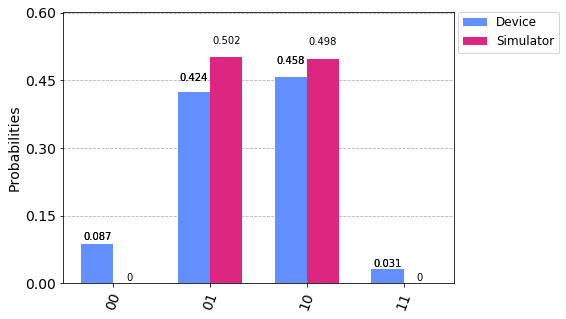

In [42]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts_sim], legend=['Device', 'Simulator'])

## 1. Quantum state tomography

Measurement in the $x$-basis is performed by applying a Hadamard gate followed by $z$-measurement. This is because $\ket{+}=\ket{0}$ and $\ket{-}=\ket{1}$. For a $y$-measurement we apply $S^\dagger H$ before $z$-measurement: $ H S^\dagger \ket{\circlearrowright} = \ket{0}$, $ H S^\dagger \ket{\circlearrowleft} = \ket{1}$.

Our goal is to construct the reduced density matrix from measurements of all possible combinations of $x$-, $y$-, and $z$-measurements (i.e. there are $3^n$ measurements for $n$ qubits). We contruct all 9 circuit corresponding to these measurements below.

In [153]:
qc = QuantumCircuit(2)
qc.x([0,1])
qc.h(0)
qc.cx(0,1)
qc_tomo = state_tomography_circuits(qc, qc.qubits)
for i in np.arange(len(qc_tomo)):
    print(qc_tomo[i])

        ┌───┐┌───┐      ░ ┌───┐┌─┐   
q_0: |0>┤ X ├┤ H ├──■───░─┤ H ├┤M├───
        ├───┤└───┘┌─┴─┐ ░ ├───┤└╥┘┌─┐
q_1: |0>┤ X ├─────┤ X ├─░─┤ H ├─╫─┤M├
        └───┘     └───┘ ░ └───┘ ║ └╥┘
c5_0: 0 ════════════════════════╩══╬═
                                   ║ 
c5_1: 0 ═══════════════════════════╩═
                                     
        ┌───┐┌───┐      ░  ┌───┐ ┌─┐        
q_0: |0>┤ X ├┤ H ├──■───░──┤ H ├─┤M├────────
        ├───┤└───┘┌─┴─┐ ░ ┌┴───┴┐└╥┘┌───┐┌─┐
q_1: |0>┤ X ├─────┤ X ├─░─┤ Sdg ├─╫─┤ H ├┤M├
        └───┘     └───┘ ░ └─────┘ ║ └───┘└╥┘
c5_0: 0 ══════════════════════════╩═══════╬═
                                          ║ 
c5_1: 0 ══════════════════════════════════╩═
                                            
        ┌───┐┌───┐      ░ ┌───┐┌─┐
q_0: |0>┤ X ├┤ H ├──■───░─┤ H ├┤M├
        ├───┤└───┘┌─┴─┐ ░ └┬─┬┘└╥┘
q_1: |0>┤ X ├─────┤ X ├─░──┤M├──╫─
        └───┘     └───┘ ░  └╥┘  ║ 
c5_0: 0 ════════════════════╬═══╩═
                            ║     
c5_1: 0 

How do we use the measurements of above circuit to construct the density matrix? Well, let's first think about the single qubit case. Here, a general density matrix is
$$
\rho = \frac{1}{2} \left(1 + c_1 \sigma_x + c_2 \sigma_y + c_3 \sigma_z \right)
$$
The $\sigma_i$ are Pauli matrices, i.e. generators of the su(2) Lie algebra. 

Measurement in the $i$-basis is given by 
$$
\langle \sigma_i \rangle = \text{Tr} \left( \rho \sigma_i \right) = 
\frac{1}{2} \text{Tr} \left( \left(1 + c_1 \sigma_x + c_2 \sigma_y + c_3 \sigma_z \right) \sigma_i \right) = c_i
$$
We see that the density matrix for a single qubit is obtained from measurements along the three axes.

For $n$ qubits we do exactly the same. Now we write
$$
\rho = \frac{1}{2^n} \left(1 + \sum_{i_1,...,i_n=0}^{3}' c_{i_1\dotsi_n} \sigma_{i_1} \sigma_{i_2} \dotsb \sigma_{i_n} \right) \,.
$$
The prime (') indicates that we are excluding the term where all indices are 0 (i.e. we do not consider the identity matrix). The $\sigma_{i_1} \sigma_{i_2} \dotsb \sigma_{i_n}$ are a particular choice of the $4^n-1$ generators of su($2^n$). The coefficents are determined through measurements of

$$ 
\langle \sigma_{i_1} \sigma_{i_2} \dotsb \sigma_{i_n} \rangle = \text{Tr} \left( \rho \sigma_{i_1} \sigma_{i_2} \dotsb \sigma_{i_n} \right) = c_{i_1i_2\dots i_n} 
$$

> **Exercise.** *Above code generates $3^2=9$ circuit. For $n$ qubits this generalizes to $3^n$ circuits. Why do we only need to measure $3^n$ circuits to compute $4^n-1$ expectation values?*

So, let us compute the density matrix for our singlet state on the actual quantum computer.

In [157]:
least_busy = providers.ibmq.least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2)[1:])
job_exp = execute(qc_tomo, backend=least_busy, shots=1024)
job_monitor(job_exp)
tomo = StateTomographyFitter(job_exp.result(), qc_tomo)
rho = tomo.fit()

Job Status: job has successfully run


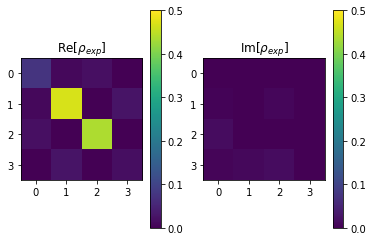

In [158]:
plot_rho(rho)

Knowledge of the density matrix $\rho$ allows us to compute the entanglement entropy. 

In [160]:
# compute entanglement entropy
evals, vecs = la.eig(rho)
s_ent = -np.sum(evals*np.log(evals))
print("Entanglement entropy: ", s_ent)

Entanglement entropy:  (0.46337100108561285-9.85185808879614e-17j)


> **Exercise.** *Why is the entanglement entropy non-zero?*

# 2. Bell's inequalities

A state as simple as the singlet allows us to test a very deep result of quantum mechanics: the violation of Bell's inequalities. Some people even go as far as calling this the most fundamental result of quantum mechanics.

So here we go. Given operators $A_i$ and $B_i$ that live on different hilbert spaces (and may even be spatially separated from each other), construct

$$
\mathcal{E} = A_0B_0 + A_0 B_1 + A_1B_0 - A_1 B_1.
$$

With a bit of algebra we can show that

$$\mathcal{E}^2 = 4\mathbf{I} - [A_0, A_1][B_0, B_1]. \tag{4} \label{E^2} $$

So, classically, it is clear that the measurement of $\mathcal{E}$ is bounded by two. This is called the [CHSH](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.23.880) bound.

For non-commuting operators we have to work harder:
$$
\begin{align*}
\langle \mathcal{E}^2\rangle & \leq ||\mathcal{E}^2|| \\
    & = ||4\mathbf{I} - [A_0,A_1][B_0, B_1]|| \\
    & \leq 4 + ||[A_0, A_1]|| \cdot ||[B_0, B_1]|| \\
    & \leq 4 + 4||A_0|| \cdot || A_1|| \cdot || B_0 || \cdot || B_1|| = 8.
\end{align*}
$$

This leads to *Tsirelson's bound* on the expectation $\langle\mathcal{E}\rangle$:

$$
|\langle\mathcal{E}\rangle|\leq \sqrt{\langle \mathcal{E}^2\rangle} =2\sqrt{2}. \tag{7}\label{tsi}
$$

$$A_0 = -\frac{Z_A + X_A}{\sqrt{2}}, \quad A_1 = \frac{Z_A - X_A}{\sqrt{2}}, \quad B_0 = X_B, \quad B_1 = Z_B .$$

In [60]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, backend='ibmqx2', shots=1000)

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

B0 = X
B1 = Z
A0 = -(Z + X)/np.sqrt(2)
A1 = (Z - X)/np.sqrt(2)

C = np.kron(A0, B0 + B1) + np.kron(A1, B0 - B1)


@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

    return qml.expval(qml.Hermitian(C, wires=[0, 1]))


expval = circuit()
print('<E> = ', expval)

<E> =  2.8284271247461885


# 3. Deutsch–Jozsa algorithm

The [Deutsch–Jozsa algorithm](https://www.isical.ac.in/~rcbose/internship/lectures2016/rt08deutschjozsa.pdf) is a toy algorithm that solves the following task on a quantum computer more more efficiently than a classical computer. Given a function 
$$
f : \{0,1\}^n \rightarrow \{0,1\} 
$$
that is 
1. either constant: $f(x)=0$ or $f(x)=1$
2. or balanced: $\sum_{x=0}^{2^n-1} f(x) = 2^{n-1}$

With a classical deterministic algorithm, the function $f(x)$ needs to be evaluated $2^{n-1}+1$ times in the worst case. We will see that the quantum algorithm only requires a single function query.

In the Deutsch–Jozsa formulation, the function $f$ is implement as the following quantum oracle. It takes $n+1$ input qubits
and returns

$$
\ket{x}\ket{1} \rightarrow \ket{x} \ket{y \oplus f(x)}
$$

Here $\ket{x} = \ket{x_0 x_1 \dots x_{n-1}}$ and $\oplus$ is addition moduloo 2.
<figure>
    <div style="text-align:center">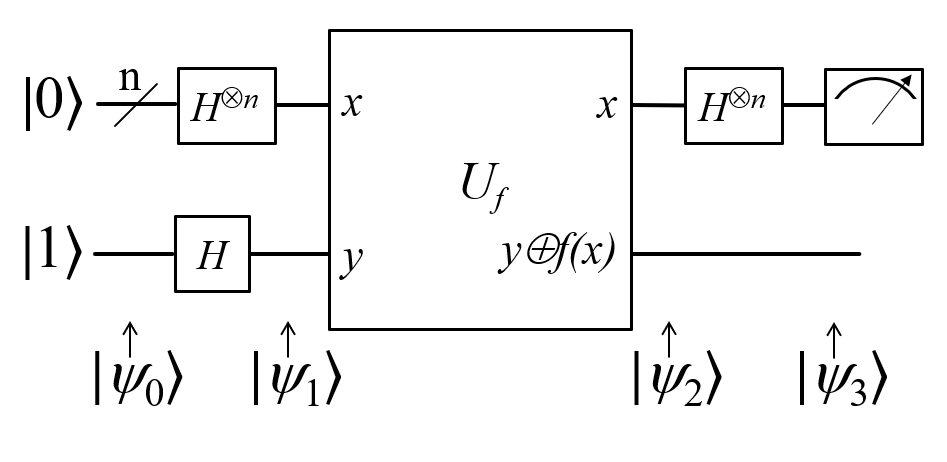
		    <figcaption><i>Figure: Figure: wikipedia CC BY-SA 4.0</i></figcaption>
	</div>
</figure>

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$




The input state $\ket{\psi_0}$ is transformed by a Hadamrd gates acting on all qubits into (up to some normalization factor)

$$
\ket{\psi_1} = \sum_{x=0}^{2^n-1} \ket{x} (\ket{0}-\ket{1})
$$

We now apply the orace to get

$$
\ket{\psi_2} = \sum_{x=0}^{2^n-1} \ket{x} (\ket{f(x)}-\ket{1 \oplus f(x)})
$$

It is easy to see that

$$
\ket{f(x)}-\ket{1 \oplus f(x)} = (-1)^{f(x)} (\ket{0}-\ket{1})
$$

i.e. each terms simply picks up a phase of $\pi$ depending on the value of $f(x)$. At this point, the last qubit may be ignored and all that remains is

$$
\ket{\psi_2} = \sum_{x=0}^{2^n-1} (-1)^{f(x)} \ket{x} 
$$

Finally, we apply Hadamard gates to all qubits. Remember that $H\ket{0} = \ket{0}+\ket{1}$ and $H\ket{1} = \ket{0}-\ket{1}$. Convince yourself that

$$
H^{\otimes n} \ket{x} = \sum_{y=0}^{2^n-1} (-1)^{x \cdot y} \ket{y}
$$

where $x \cdot y = x_0 y_0 \oplus x_1 y_1 \oplus \dots \oplus x_n y_n$ is the bitwise product. Then we have

$$
\ket{\psi_3} = \sum_{y=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x\cdot y} \ket{y}
$$

Finally, we perform a measurement in the computational (z-) basis. The probability of getting $\ket{0}$ is (now putting the normalization back in)

$$
\left| \frac{1}{2^n} \sum_{y=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x\cdot y} \langle 0 | y \rangle \right|^2 
=
\left| \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)}\right|^2
$$

which sums to zero if $f(x)$ is balanced or gives 1 if it is constant.


# 4. Identification of symmetry-protected topological states on noisy quantum computers [arXiv:2002.04620](https://arxiv.org/pdf/2002.04620.pdf)

The groundstate of the Hamiltonian
$$
H_{\text{cluster}} = - \sum_i h_i = - \sum_i Z_{i-1} X_i Z_{i+1}
$$
is called *cluster state*. They are useful in the context of *measurement based quantum computation* (recall Tarun's group meeting talk). Teh $h_i$ are referred to as stabilizer. The cluster state can also be generated by the following unitary circuit:

In [174]:
qc = QuantumCircuit(4)
qc.h([0,1,2,3])
qc.cz([1,2,0],[2,3,1])
print(qc)

        ┌───┐      
q_0: |0>┤ H ├────■─
        ├───┤    │ 
q_1: |0>┤ H ├─■──■─
        ├───┤ │    
q_2: |0>┤ H ├─■──■─
        ├───┤    │ 
q_3: |0>┤ H ├────■─
        └───┘      


For us it is important that the cluster state realizes a SPT state that is protexted by the $\mathbf{Z}_2 \times \mathbf{Z}$ symmetry group generated by $\{X_1 X_3 Z_4, \, Z_1X_2 X_4\}$. According to their definition, SPT states cannot be deformed into a product state by any symmetry preserving unitary.

It also turns out that SPT states are an excisite resoure for measurement based quantum computation (MBQC) . The simplest example of MBQC is teleportation. Below, we implement such a teleportation circuit. 

A qubit $\ket{\psi_{in}}$ is teleported into the upper end of the cluster state and then shuttled to ther other end by measurements in the $x$-basis. Up to some classical Pauli-correction, we recover it as $\ket{\psi_{out}}$.

All of this also works if we apply some symmetry preserving unitaries to the cluster state. If the unitaries, however, break the symmetries, the teleportation process fails. This property may be used as a probe of SPT order.

<figure>
    <div style="text-align:center"><img src="qc.jpg" width="58%"/>
		    <figcaption><i></i></figcaption>
	</div>
</figure>

<figure>
    <div style="text-align:center"><img src="5_sim_min_fidelity_mitigated.png" width="58%"/>
		    <figcaption><i></i></figcaption>
	</div>
</figure>

# 5. Quantum Neural Networks (Quantum Machine Learning)

We are given a bunch of data pairs $(x_i,y_i)$. In the machine learning community, the $x_i$ are usually called *features* and could be some high-dimenional object (like a picture). The $y_i$ are called *labels*. We want to train a neural network $f(\theta_k, x_i)$ such that 

$$
y_i = f(\theta_k, x_i)
$$

We do this by optimizing the cost-function $\sum_i \left(y_i - f(\theta_k, x_i)\right)^2 $ with respect to the $\theta_k$.

The quantum analogue to classical neural networks is the expectation value

$$
f(\theta_k, x_i) = \bra{0} U_E^\dagger(x_i) U_L^\dagger(\theta_k) O  U_L(\theta_k) U_E(x_i) \ket{0}
$$

$U_E(x)$ is a unitary called the *feature map* that embed the classical data $x_i$ into the wavefunction. $U_L$ corresponds to the network and may include a bunch of layered (repeated unitaries) that depend on the classical training parameters $\theta_i$. $O$ is some operator. Naturally, is is not allowed to commute with the $U_L$.

<figure>
    <div style="text-align:center"><img src="nn.png" width="88%"/>
		    <figcaption><i>Figure: pennylane.ai (ammended by Rafael)</i></figcaption>
	</div>
</figure>

### Prediction of COVID-19 using a quantum neural network

Below we show the data (as of yesterday) of confirmed COVID-19 related deaths.

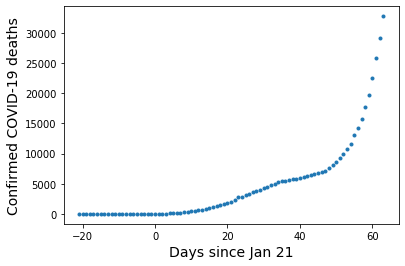

In [5]:
data = np.loadtxt('covid.csv', skiprows=1, delimiter=',')
X = data[:,0]
xmax = np.max(X)
Y = data[:,1]
ymax = np.max(Y)

plt.figure()
plt.plot(X, Y, '.')
plt.xlabel("Days since Jan 21", fontsize=14)
plt.ylabel("Confirmed COVID-19 deaths", fontsize=14)

X = X/xmax
Y = Y/ymax

plt.show()

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)


@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

Having defined the structure of our neural network, it is time to learn it. This process can take a couple hours even for our simple network.

In [18]:
np.random.seed(0)
num_layers = 6
var_init = 0.1 * np.random.randn(num_layers, 5)

opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(2):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.1917569 
Iter:     2 | Cost: 0.1608597 


And here are the predictions.

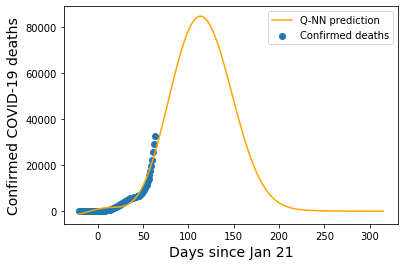

In [17]:
var= np.array([[ 0.1672444 , -0.02746   ,  0.08835575,  0.18722878,  0.18929305],
                    [-0.0957819 ,  0.12777733, -0.01524759, -0.05143529,  0.05080969],
                    [ 0.01374947,  0.18976937,  0.08813493, -0.02532584,  0.07449287],
                    [ 0.04830769,  0.16256158,  0.02936889, -0.00605395, -0.05571956],
                    [-0.20538369,  0.10427885,  0.12307134, -0.11345193,  0.24573954],
                    [-0.10939146, -0.01677891,  0.02856047,  0.1096455 ,  0.16252224]])

x_pred = np.linspace(np.min(X), np.max(X)*5, 100)
predictions = np.array([quantum_neural_net(var, x=x_) for x_ in x_pred])

plt.figure()
plt.scatter(X*xmax, Y*ymax, label='Confirmed deaths')
plt.plot(x_pred*xmax, predictions*ymax, color="orange", label='Q-NN prediction')
plt.xlabel("Days since Jan 21", fontsize=14)
plt.ylabel("Confirmed COVID-19 deaths", fontsize=14)
plt.legend()
plt.show()